In [1]:
# import trax
# from trax import layers as tl
# import trax.fastmath.numpy as fastnp
# from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
import random as rnd
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import copy
import torch
import os
import warnings
from scipy.spatial import distance
from os import walk
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#initialize codebert
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codebert = AutoModel.from_pretrained("microsoft/codebert-base").to(device)
np.random.seed(777)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from os import walk

from transformers import AutoModelForCausalLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

int_to_label_pre = {
    0: 'notFlaky',
    1: 'Flaky',
    
}

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = "/home/riddhi/FlakyXbert/MAIN/data/IDoFT_data/Flakify_IDoFT_dataset.csv"
data = pd.read_csv(file_path)

# Filter data for a specific project
project_name = "nifi"  # Replace 'YourProjectName' with the actual project name
filtered_data = data[data['project'] == project_name]  # Replace 'project' with the actual column name identifying the project

# Extract the relevant fields: 'preprocessed_code' and 'flaky'
relevant_data = filtered_data[['preprocessed_code', 'flaky']]

# Split the data into training and validation sets, stratifying by 'flaky' to ensure all categories are represented
train_data, valid_data = train_test_split(relevant_data, test_size=0.2, random_state=42, stratify=relevant_data['flaky'])

# Replace category numbers with category labels
# Ensure 'int_to_label_pre' is defined, mapping integer labels to their corresponding category names
train_data['category'] = train_data['flaky'].map(int_to_label_pre)
valid_data['category'] = valid_data['flaky'].map(int_to_label_pre)

# Extract buggy code and categories for train and validation sets
train_buggy_code = train_data['preprocessed_code'].tolist()
valid_buggy_code = valid_data['preprocessed_code'].tolist()
train_categories = train_data['category'].tolist()
valid_categories = valid_data['category'].tolist()

# Print the splits for verification
print("Train buggy code:", len(train_buggy_code))
print("Validation buggy code:", len(valid_buggy_code))
print("Train categories:", len(train_categories))
print("Validation categories:", len(valid_categories))


Train buggy code: 116
Validation buggy code: 30
Train categories: 116
Validation categories: 30


In [5]:
label_to_int= {
    'notFlaky': 0,
    'Flaky': 1
    }

In [6]:
from torch.utils.data import Dataset
import numpy as np
import random
import torch

class SiameseDataset(Dataset):
    def __init__(self, train_buggy_code, valid_buggy_code, tokenizer, codebert, categories, split):
        self.train_buggy_code = train_buggy_code
        self.valid_buggy_code = valid_buggy_code
        self.tokenizer = tokenizer
        self.codebert = codebert.to(device)
        self.categories = categories
        self.split = split
        self.m_len = self.calculate_max_output_length()
        
        # Preprocess categories to map labels to indices
        self.label_to_indices = {}
        for index, category in enumerate(categories):
            if category not in self.label_to_indices:
                self.label_to_indices[category] = []
            self.label_to_indices[category].append(index)

        # For negative sampling
        self.labels = categories
        self.unique_labels = list(set(self.labels))
        
    def calculate_max_output_length(self):
        max_length = 0
        for code in self.train_buggy_code:
            # Simulate processing of snippets to determine the concatenated output length
            length = self.simulate_process_length(code)
            if length > max_length:
                max_length_train = length
        for code in self.valid_buggy_code:
            # Simulate processing of snippets to determine the concatenated output length
            length = self.simulate_process_length(code)
            if length > max_length:
                max_length_valid = length
        if max_length_train > max_length_valid:
            return max_length_train
        else:
            return max_length_valid

    def simulate_process_length(self, snippet):
        # Calculate how many segments would be needed
        encoded_input = self.tokenizer.encode(snippet, add_special_tokens=True)
        # Each segment processes up to 512 tokens (max length for BERT models)
        num_segments = (len(encoded_input) + 511) // 512  # 512 tokens per segment, including CLS and SEP
        return num_segments * 768
    def __len__(self):
        if self.split == 'train':
            return len(self.train_buggy_code)
        else:
            return len(self.valid_buggy_code)

    def __getitem__(self, idx):
        if self.split == 'train':
            # Anchor label
            anchor_label = self.categories[idx]

            # Positive sample
            positive_idx = idx
            while positive_idx == idx:  # Ensure different indices for anchor and positive
                positive_idx = random.choice(self.label_to_indices[anchor_label])

            # Negative sample
            negative_label = random.choice([lab for lab in self.unique_labels if lab != anchor_label])
            negative_idx = random.choice(self.label_to_indices[negative_label])

            anchor = self._process_snippet(self.train_buggy_code[idx])
            positive = self._process_snippet(self.train_buggy_code[positive_idx])
            negative = self._process_snippet(self.train_buggy_code[negative_idx])
            
            if len(anchor) <= 768:
                short_data = True
            else:
                short_data = False
                


            return {
                'anchor': torch.nn.functional.pad(anchor, (0, self.m_len - anchor.size(0))),
                'positive':torch.nn.functional.pad(positive, (0, self.m_len - positive.size(0))),
                'negative': torch.nn.functional.pad(negative, (0, self.m_len - negative.size(0))),
                'label': label_to_int[anchor_label],  # Optional, depends on how you want to use it
                'short_data_flag': short_data
            }
        elif self.split == 'val':
            anchor_label = self.categories[idx]
            anchor = self._process_snippet(self.valid_buggy_code[idx])
            
            return {
                'anchor': torch.nn.functional.pad(anchor, (0, self.m_len - anchor.size(0))),
                'label': label_to_int[anchor_label]  # Optional, depends on how you want to use it
            }

        
    def _process_snippet(self, snippet):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Tokenize input without the max_length constraint
        inputs = self.tokenizer(snippet, return_tensors='pt').to(device)

        if inputs['input_ids'].shape[1] < 512:
            with torch.no_grad():
                outs = self.codebert(**inputs)
            cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
            return cls  # Move to CPU to save GPU memory
        else:
            total_length = inputs['input_ids'].shape[1]
            parts = []
            step_size = 100
            chunk_size = 512

            for start_index in range(0, total_length, step_size):
                end_index = min(start_index + chunk_size, total_length)
                input_segment = {key: val[:, start_index:end_index].to(device) for key, val in inputs.items()}

                with torch.no_grad():
                    output_segment = self.codebert(**input_segment)
                cls_segment = output_segment.last_hidden_state[:, 0, :].squeeze().detach()
                parts.append(cls_segment)  # Move to CPU

            concatenated_parts = torch.cat(parts, dim=0)
            return concatenated_parts

In [7]:
# Create instances of the custom dataset class
train_dataset = SiameseDataset(train_buggy_code, valid_buggy_code, tokenizer, model_codebert, train_categories, 'train')
val_dataset = SiameseDataset(train_buggy_code, valid_buggy_code, tokenizer, model_codebert, valid_categories, 'val')

# Create dataloaders for training and validation
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Print the lengths of the dataloaders for verification
print("Train dataloader length:", len(train_dataloader))
print("Validation dataloader length:", len(val_dataloader))

Token indices sequence length is longer than the specified maximum sequence length for this model (932 > 512). Running this sequence through the model will result in indexing errors


Train dataloader length: 15
Validation dataloader length: 4


In [8]:
import numpy as np

def sample_triplet_data(data, sample_size_ratio):
    """
    Samples a subset of triplet data (anchor, positive, negative) while preserving class distribution.
    
    Parameters:
    - data: list of dictionaries, where each dictionary has keys 'anchor', 'positive', 'negative', 'label'.
    - sample_size_ratio: float, the fraction of the data to sample (0 < sample_size_ratio <= 1).
    
    Returns:
    - sampled_data: list of dictionaries, the sampled subset of the original data.
    """
    # Extract labels to understand the class distribution
    labels = [item['label'] for item in data]
    unique_classes = np.unique(labels)
    
    sampled_data = []
    
    for cls in unique_classes:
        # Find all items belonging to the current class
        class_items = [item for item in data if item['label'] == cls]
        # Calculate the number of items to sample from this class
        num_samples = int(np.ceil(len(class_items) * sample_size_ratio))
        # Randomly sample items without replacement
        sampled_items = np.random.choice(class_items, size=num_samples, replace=False)
        # Append the sampled items to the output list
        sampled_data.extend(sampled_items)
    
    # Optionally, shuffle the sampled dataset to mix classes
    np.random.shuffle(sampled_data)

    return sampled_data


In [9]:
import gc
from tqdm import tqdm
plot_data = []
plot_labels = []
short_data_flags = []
for item in tqdm(train_dataset):
    
    plot_data.append(item['anchor'])
    plot_labels.append(item['label'])
    short_data_flags.append(item['short_data_flag'])

  0%|          | 0/116 [00:00<?, ?it/s]

100%|██████████| 116/116 [00:02<00:00, 49.84it/s]


In [10]:
m_len = plot_data[0].shape[0]

In [11]:
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']  
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap
cc = LinearSegmentedColormap.from_list("cc", colors, N=5)


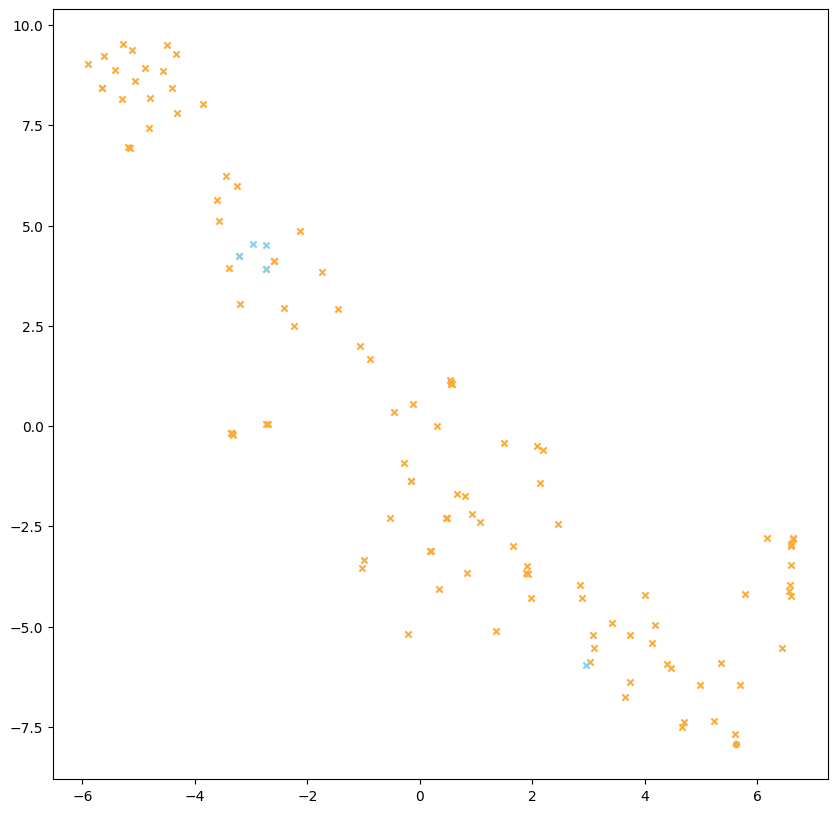

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

# Assuming X, plot_data, and plot_labels are defined as before
# Also assuming bool_values is your list/array of boolean values

X = torch.stack(plot_data).cpu().numpy()

# Extract labels for each point
labelsNums = plot_labels

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# Assuming 'cc' is a colormap, you might need to adjust this to fit your actual colormap variable
# Generate an array of colors for each label
unique_labels = np.unique(labelsNums)
colors = plt.cm.get_cmap(cc, len(unique_labels))  # Adjust 'cc' as needed to your colormap name
label_to_color = {label: colors(i / len(unique_labels)) for i, label in enumerate(unique_labels)}
colors_array = np.array([label_to_color[label] for label in labelsNums])

# Create the scatter plot
plt.figure(figsize=(10, 10))

# Iterate through each datapoint
for i in range(len(X_embedded)):
    marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors_array[i], s=20, alpha=1, marker=marker)

# Set the background color to black
# plt.gca().set_facecolor('white')
# # Adjust the color of the ticks and labels for better visibility
# plt.tick_params(axis='x', colors='white')
# plt.tick_params(axis='y', colors='white')
# plt.xlabel('Component 1', color='white')
# plt.ylabel('Component 2', color='white')

plt.show()


In [13]:
# Load the CodeBERT tokenizer (adjust the model_name as needed)
model_name = "microsoft/codebert-base"
codebert_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_size, int(embedding_size/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/2), int(embedding_size/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/4), embedding_size)
        )

    def forward(self, x):
        output = self.fc(x)
        return output

In [14]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [15]:
learning_rate = 1e-5
num_epochs = 450
embed_size = m_len  # This should match the output size of CodeBERT
siamese_network = SiameseNetwork(embed_size).to(device)
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(siamese_network.parameters(), lr=learning_rate)
triplet_loss = TripletLoss().to(device)

In [16]:
# from transformers import get_linear_schedule_with_warmup
# warmup_Frac = 0.1
# total_iter = num_epochs * len(train_dataloader)
# scheduler = get_linear_schedule_with_warmup(optimizer, int(warmup_Frac * total_iter), total_iter)

In [31]:
from tqdm import tqdm
best_loss = 100.0
num_epochs = 100
epoch_loss_list = []
model_name = "FlakyXbert_IDoFT_project_binary_" + project_name + '_final.pth'
for epoch in range(num_epochs):
    total_loss = 0.0
    siamese_network.train()
    for batch in tqdm(train_dataloader):

        labels = (batch['label']).to(device)
        batch_anchor = (batch['anchor']).to(device)
        batch_positive = (batch['positive']).to(device)
        batch_negative = (batch['negative']).to(device)

        anchor_output = siamese_network(batch_anchor)
        positive_out = siamese_network(batch_positive)
        negative_out = siamese_network(batch_negative)

        loss = criterion(anchor_output, positive_out, negative_out)
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(siamese_network.parameters(), max_norm=2.0)        
        optimizer.step()
        # scheduler.step()

        total_loss += loss.item()
        if total_loss <= best_loss:
            # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
            print("Loss improved saving model")
            torch.save(siamese_network.state_dict(), model_name)
            best_loss = total_loss
        
            
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    # The line `epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")` is attempting to append a formatted string to a list named `epoch_loss_list`. This string contains information about the current epoch number, total number of epochs, and the average loss calculated for that epoch. However, in the provided code snippet, the `epoch_loss_list` list is not defined or used anywhere else in the code.
    epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    

 13%|█▎        | 2/15 [00:00<00:02,  5.92it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  5.61it/s]


Epoch 1/100, Loss: 0.10133117636044821


 13%|█▎        | 2/15 [00:00<00:02,  5.04it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  4.93it/s]


Epoch 2/100, Loss: 0.11335863123337428


  7%|▋         | 1/15 [00:00<00:02,  4.69it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:02,  4.57it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  5.21it/s]


Epoch 3/100, Loss: 0.12586226016283036


100%|██████████| 15/15 [00:02<00:00,  5.31it/s]


Epoch 4/100, Loss: 0.13772384723027548


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


Epoch 5/100, Loss: 0.12980698098738988


100%|██████████| 15/15 [00:02<00:00,  5.26it/s]


Epoch 6/100, Loss: 0.11271022607882818


100%|██████████| 15/15 [00:02<00:00,  5.02it/s]


Epoch 7/100, Loss: 0.16384704361359279


100%|██████████| 15/15 [00:02<00:00,  5.94it/s]


Epoch 8/100, Loss: 0.08825858583052953


  7%|▋         | 1/15 [00:00<00:03,  4.06it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  4.94it/s]


Epoch 9/100, Loss: 0.13214171876509984


100%|██████████| 15/15 [00:03<00:00,  4.98it/s]


Epoch 10/100, Loss: 0.10979019552469253


  7%|▋         | 1/15 [00:00<00:02,  5.21it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:02,  5.74it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  5.51it/s]


Epoch 11/100, Loss: 0.15152003169059752


100%|██████████| 15/15 [00:02<00:00,  5.52it/s]


Epoch 12/100, Loss: 0.149990185101827


100%|██████████| 15/15 [00:02<00:00,  5.32it/s]


Epoch 13/100, Loss: 0.13041136165459952


100%|██████████| 15/15 [00:02<00:00,  5.41it/s]


Epoch 14/100, Loss: 0.10845895608266194


100%|██████████| 15/15 [00:02<00:00,  5.83it/s]


Epoch 15/100, Loss: 0.11573193321625391


100%|██████████| 15/15 [00:02<00:00,  5.76it/s]


Epoch 16/100, Loss: 0.10918295681476593


100%|██████████| 15/15 [00:02<00:00,  5.07it/s]


Epoch 17/100, Loss: 0.08024174074331919


100%|██████████| 15/15 [00:02<00:00,  5.65it/s]


Epoch 18/100, Loss: 0.1599875415364901


  7%|▋         | 1/15 [00:00<00:02,  5.82it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  5.39it/s]


Epoch 19/100, Loss: 0.07178007215261459


  7%|▋         | 1/15 [00:00<00:02,  5.39it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  5.69it/s]


Epoch 20/100, Loss: 0.13093405812978745


  7%|▋         | 1/15 [00:00<00:02,  5.05it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  5.77it/s]


Epoch 21/100, Loss: 0.15561747749646504


100%|██████████| 15/15 [00:03<00:00,  4.82it/s]


Epoch 22/100, Loss: 0.13194110840559006


 13%|█▎        | 2/15 [00:00<00:02,  4.88it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  4.80it/s]


Epoch 23/100, Loss: 0.09658262530962626


  7%|▋         | 1/15 [00:00<00:03,  4.30it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  5.04it/s]


Epoch 24/100, Loss: 0.12681795010964075


 13%|█▎        | 2/15 [00:00<00:02,  5.34it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  5.59it/s]


Epoch 25/100, Loss: 0.10124350637197495


100%|██████████| 15/15 [00:02<00:00,  5.31it/s]


Epoch 26/100, Loss: 0.11356000204881032


100%|██████████| 15/15 [00:02<00:00,  5.55it/s]


Epoch 27/100, Loss: 0.13554238627354304


  0%|          | 0/15 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  5.07it/s]


Epoch 28/100, Loss: 0.13319325645764668


100%|██████████| 15/15 [00:02<00:00,  5.48it/s]


Epoch 29/100, Loss: 0.11181744237740834


100%|██████████| 15/15 [00:02<00:00,  5.05it/s]


Epoch 30/100, Loss: 0.09443589995304744


  7%|▋         | 1/15 [00:00<00:02,  5.66it/s]

Loss improved saving model


 20%|██        | 3/15 [00:00<00:02,  5.44it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  5.32it/s]


Epoch 31/100, Loss: 0.14914229611555735


  7%|▋         | 1/15 [00:00<00:02,  6.10it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  5.43it/s]


Epoch 32/100, Loss: 0.11467513094345728


100%|██████████| 15/15 [00:03<00:00,  4.92it/s]


Epoch 33/100, Loss: 0.08638055523236593


100%|██████████| 15/15 [00:02<00:00,  5.77it/s]


Epoch 34/100, Loss: 0.12776812215646108


100%|██████████| 15/15 [00:02<00:00,  5.59it/s]


Epoch 35/100, Loss: 0.08458372553189596


100%|██████████| 15/15 [00:02<00:00,  5.07it/s]


Epoch 36/100, Loss: 0.10399415095647176


100%|██████████| 15/15 [00:02<00:00,  5.37it/s]


Epoch 37/100, Loss: 0.10264762391646703


 13%|█▎        | 2/15 [00:00<00:02,  4.79it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  5.44it/s]


Epoch 38/100, Loss: 0.1583675727248192


  7%|▋         | 1/15 [00:00<00:02,  5.72it/s]

Loss improved saving model


100%|██████████| 15/15 [00:03<00:00,  4.92it/s]


Epoch 39/100, Loss: 0.09964444488286972


100%|██████████| 15/15 [00:02<00:00,  5.44it/s]


Epoch 40/100, Loss: 0.11169107506672542


  7%|▋         | 1/15 [00:00<00:03,  4.59it/s]

Loss improved saving model


 20%|██        | 3/15 [00:00<00:02,  5.02it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  5.59it/s]


Epoch 41/100, Loss: 0.12339177578687668


100%|██████████| 15/15 [00:02<00:00,  5.31it/s]


Epoch 42/100, Loss: 0.08895048846801122


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


Epoch 43/100, Loss: 0.08590616335471471


100%|██████████| 15/15 [00:02<00:00,  5.48it/s]


Epoch 44/100, Loss: 0.09169116169214249


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


Epoch 45/100, Loss: 0.10777425467967987


100%|██████████| 15/15 [00:02<00:00,  5.18it/s]


Epoch 46/100, Loss: 0.10476776113112768


 13%|█▎        | 2/15 [00:00<00:02,  4.53it/s]

Loss improved saving model


100%|██████████| 15/15 [00:02<00:00,  5.42it/s]


Epoch 47/100, Loss: 0.09429825693368912


100%|██████████| 15/15 [00:02<00:00,  5.49it/s]


Epoch 48/100, Loss: 0.15436325172583262


100%|██████████| 15/15 [00:02<00:00,  7.22it/s]


Epoch 49/100, Loss: 0.10352658629417419


100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Epoch 50/100, Loss: 0.1159844199816386


  7%|▋         | 1/15 [00:00<00:01,  9.29it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


Epoch 51/100, Loss: 0.096540633837382


  7%|▋         | 1/15 [00:00<00:01,  9.34it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Epoch 52/100, Loss: 0.11367818067471186


100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Epoch 53/100, Loss: 0.1365844542781512


100%|██████████| 15/15 [00:01<00:00,  8.72it/s]


Epoch 54/100, Loss: 0.1303085928161939


100%|██████████| 15/15 [00:01<00:00,  9.11it/s]


Epoch 55/100, Loss: 0.11102315038442612


  7%|▋         | 1/15 [00:00<00:01,  9.56it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:01,  9.71it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Epoch 56/100, Loss: 0.10005657821893692


100%|██████████| 15/15 [00:01<00:00,  9.04it/s]


Epoch 57/100, Loss: 0.12560862600803374


100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Epoch 58/100, Loss: 0.0953913226723671


100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


Epoch 59/100, Loss: 0.10791820287704468


100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Epoch 60/100, Loss: 0.09524678041537603


  7%|▋         | 1/15 [00:00<00:02,  5.65it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  9.20it/s]


Epoch 61/100, Loss: 0.10062630126873652


  7%|▋         | 1/15 [00:00<00:01,  9.53it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Epoch 62/100, Loss: 0.11247289379437765


100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Epoch 63/100, Loss: 0.10163521269957225


100%|██████████| 15/15 [00:01<00:00,  9.04it/s]


Epoch 64/100, Loss: 0.18779111454884212


100%|██████████| 15/15 [00:01<00:00,  9.11it/s]


Epoch 65/100, Loss: 0.11302966276804606


100%|██████████| 15/15 [00:01<00:00,  9.06it/s]


Epoch 66/100, Loss: 0.10658453653256099


100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Epoch 67/100, Loss: 0.09418312758207321


100%|██████████| 15/15 [00:01<00:00,  8.56it/s]


Epoch 68/100, Loss: 0.1344618171453476


100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Epoch 69/100, Loss: 0.12657214999198912


100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Epoch 70/100, Loss: 0.10565391927957535


  7%|▋         | 1/15 [00:00<00:01,  9.55it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:01,  9.67it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  9.11it/s]


Epoch 71/100, Loss: 0.07047288318475088


100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Epoch 72/100, Loss: 0.14285264362891514


100%|██████████| 15/15 [00:01<00:00,  9.28it/s]


Epoch 73/100, Loss: 0.10373962273200353


  7%|▋         | 1/15 [00:00<00:01,  9.60it/s]

Loss improved saving model
Loss improved saving model


 20%|██        | 3/15 [00:00<00:01,  9.96it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  9.04it/s]


Epoch 74/100, Loss: 0.08269626994927724


100%|██████████| 15/15 [00:01<00:00,  9.09it/s]


Epoch 75/100, Loss: 0.12250008930762608


  7%|▋         | 1/15 [00:00<00:01,  9.67it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Epoch 76/100, Loss: 0.12136164158582688


100%|██████████| 15/15 [00:01<00:00,  9.09it/s]


Epoch 77/100, Loss: 0.11598367393016815


100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Epoch 78/100, Loss: 0.11886285841464997


100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Epoch 79/100, Loss: 0.13695381134748458


100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Epoch 80/100, Loss: 0.1129215568304062


  7%|▋         | 1/15 [00:00<00:01,  9.28it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:01,  9.54it/s]

Loss improved saving model


 20%|██        | 3/15 [00:00<00:01,  9.60it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Epoch 81/100, Loss: 0.09670388251543045


100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Epoch 82/100, Loss: 0.12608916560808817


100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Epoch 83/100, Loss: 0.10116127928098043


  7%|▋         | 1/15 [00:00<00:02,  5.79it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  8.67it/s]


Epoch 84/100, Loss: 0.09962507287661235


100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Epoch 85/100, Loss: 0.13457131733496983


100%|██████████| 15/15 [00:01<00:00,  9.20it/s]


Epoch 86/100, Loss: 0.10950409322977066


  7%|▋         | 1/15 [00:00<00:01,  9.47it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:01,  8.30it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Epoch 87/100, Loss: 0.10304658015569051


  7%|▋         | 1/15 [00:00<00:01,  9.26it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:01,  9.37it/s]

Loss improved saving model


 20%|██        | 3/15 [00:00<00:01,  9.18it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  9.26it/s]


Epoch 88/100, Loss: 0.14304806540409723


100%|██████████| 15/15 [00:01<00:00,  9.01it/s]


Epoch 89/100, Loss: 0.08365734418233235


  7%|▋         | 1/15 [00:00<00:01,  9.52it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Epoch 90/100, Loss: 0.11224643041690191


100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Epoch 91/100, Loss: 0.09404325981934865


  7%|▋         | 1/15 [00:00<00:01,  9.27it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:01,  7.31it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Epoch 92/100, Loss: 0.1119477982322375


100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Epoch 93/100, Loss: 0.09496906797091166


100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Epoch 94/100, Loss: 0.09588033656279246


  7%|▋         | 1/15 [00:00<00:01,  9.86it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  9.34it/s]


Epoch 95/100, Loss: 0.09806968669096629


  7%|▋         | 1/15 [00:00<00:01,  9.27it/s]

Loss improved saving model


 13%|█▎        | 2/15 [00:00<00:01,  7.35it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Epoch 96/100, Loss: 0.09809190879265467


100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Epoch 97/100, Loss: 0.11153625299533208


100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Epoch 98/100, Loss: 0.10295401861270269


100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Epoch 99/100, Loss: 0.11995625446240107


  7%|▋         | 1/15 [00:00<00:01,  9.56it/s]

Loss improved saving model


100%|██████████| 15/15 [00:01<00:00,  9.27it/s]

Epoch 100/100, Loss: 0.14317278911670048


In [32]:
epoch_loss_list[-50:]

['Epoch 51/100, Loss: 0.096540633837382',
 'Epoch 52/100, Loss: 0.11367818067471186',
 'Epoch 53/100, Loss: 0.1365844542781512',
 'Epoch 54/100, Loss: 0.1303085928161939',
 'Epoch 55/100, Loss: 0.11102315038442612',
 'Epoch 56/100, Loss: 0.10005657821893692',
 'Epoch 57/100, Loss: 0.12560862600803374',
 'Epoch 58/100, Loss: 0.0953913226723671',
 'Epoch 59/100, Loss: 0.10791820287704468',
 'Epoch 60/100, Loss: 0.09524678041537603',
 'Epoch 61/100, Loss: 0.10062630126873652',
 'Epoch 62/100, Loss: 0.11247289379437765',
 'Epoch 63/100, Loss: 0.10163521269957225',
 'Epoch 64/100, Loss: 0.18779111454884212',
 'Epoch 65/100, Loss: 0.11302966276804606',
 'Epoch 66/100, Loss: 0.10658453653256099',
 'Epoch 67/100, Loss: 0.09418312758207321',
 'Epoch 68/100, Loss: 0.1344618171453476',
 'Epoch 69/100, Loss: 0.12657214999198912',
 'Epoch 70/100, Loss: 0.10565391927957535',
 'Epoch 71/100, Loss: 0.07047288318475088',
 'Epoch 72/100, Loss: 0.14285264362891514',
 'Epoch 73/100, Loss: 0.10373962273200

In [33]:
siamese_network.load_state_dict(torch.load(model_name))


<All keys matched successfully>

In [34]:
siamese_network.to(device).eval()
post_train_embed = []
post_train_label = []
with torch.no_grad():
    for item in tqdm(train_dataset):
        post_train_embed.append(siamese_network(item['anchor']))
        post_train_label.append(item['label'])

 16%|█▌        | 18/116 [00:00<00:01, 80.10it/s]

100%|██████████| 116/116 [00:01<00:00, 76.76it/s]


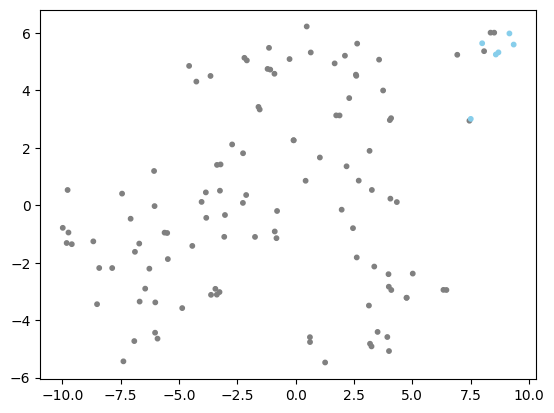

In [35]:
%matplotlib inline

X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label
X_embedded= TSNE(n_components=2, init='random').fit_transform(X_np)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1] , c=labelsNums[:len(X_embedded)], s=10, cmap= cc , alpha=1 )


In [36]:
def clsembed(snippet):
    inputs = tokenizer(snippet, padding='max_length', max_length=218, truncation=True, return_tensors='pt').to(device)
    #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
    if(len(inputs)<512):
        with torch.no_grad():
            outs = model_codebert(**inputs)
        cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        return cls
    else:
        print('longtest')
        i = 0
        part_vector =  []
        while ( i < len(inputs)-200) :
            #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
            #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
            input_seg = [tokenizer.cls_token] + inputs[i:i+250] +[tokenizer.sep_token]
            with torch.no_grad():
                ots = model_codebert(**input_seg)
            cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
            #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
            #vector = cls[0].detach().numpy()
            parts.append(cls)
            i = i+100
        return parts

In [37]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
#labels_all = ['async wait','unordered collections','concurrency','time']
def get_class_rep(post_train_embed, post_train_label):
    # Move each tensor to CPU, convert to numpy, and collect in a list
    #post_train_embed = [x.cpu().numpy() for x in post_train_embed]
    # If you want to combine them into a single array (assuming they have the same shape)
    #post_train_embed = np.concatenate(post_train_embed, axis=0)
    representatives = [None] * 2
    for label in range(2):
        indices = np.where(np.atleast_1d(post_train_label) == label)[0]  # Get the indices as an array
        class_vectors = [post_train_embed[i] for i in indices]  # Access each index individually
        class_vectors = [x.cpu().numpy() for x in class_vectors]
        representatives[label] = np.mean(class_vectors, axis=0)
    return representatives

def calculate_normalized_distance(vec1, vec2):
    # Ensure vec1 and vec2 are numpy arrays
    if not isinstance(vec1, np.ndarray):
        vec1 = vec1.cpu().detach().numpy()
    if not isinstance(vec2, np.ndarray):
        vec2 = vec2.cpu().detach().numpy()
    
    # Normalize each vector to have unit length
    norm_vec1 = vec1 / np.linalg.norm(vec1)
    norm_vec2 = vec2 / np.linalg.norm(vec2)
    
    # Calculate Euclidean (L2) distance between the normalized vectors
    distance = np.linalg.norm(norm_vec1 - norm_vec2)
    
    return distance


In [38]:
int_to_label={
    0: 'notFlaky',
    1: 'Flaky'
    }


def get_closest_cluster(cluster_representatives, projected_vector):
    distances = [calculate_normalized_distance(rep, projected_vector) for rep in cluster_representatives]
    for i in range(len(distances)):
        distances[i] = np.mean(distances[i])
    closest_cluster_idx = np.argmin(distances)
    return int_to_label[closest_cluster_idx]

In [39]:
embed = post_train_embed
labels = post_train_label
def predict(input_vector):
    modified_vector = siamese_network(input_vector)
    representatives = get_class_rep(embed, labels)
    return get_closest_cluster(representatives, modified_vector)
    


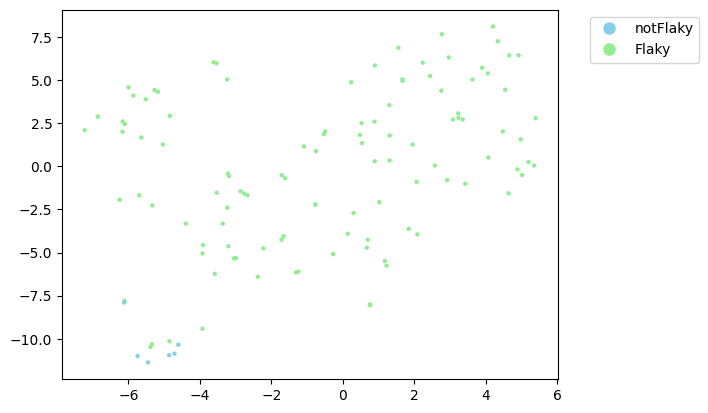

In [40]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed and post_train_label are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label

# Define vibrant colors for each category (same as used in the bar plot)
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']

# Ensure labels are within the range of colors [0, 1, 2, 3, 4]
# Filter out invalid labels (-1) and keep only valid labels [0, 1, 2, 3, 4]
valid_indices = [i for i, label in enumerate(labelsNums) if label in [0, 1]]
X_np_filtered = X_np[valid_indices]
labelsNums_filtered = [labelsNums[i] for i in valid_indices]

# Dimensionality reduction with t-SNE
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np_filtered)

# Scatter plot
for i, label in enumerate(labelsNums_filtered):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[label], s=10, alpha=1, edgecolor='none', marker='o')

# Create legend with category labels
legend_labels = ['notFlaky', 'Flaky']
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors], labels=legend_labels,bbox_to_anchor=(1.05, 1), 
                    loc='upper left')

plt.show()


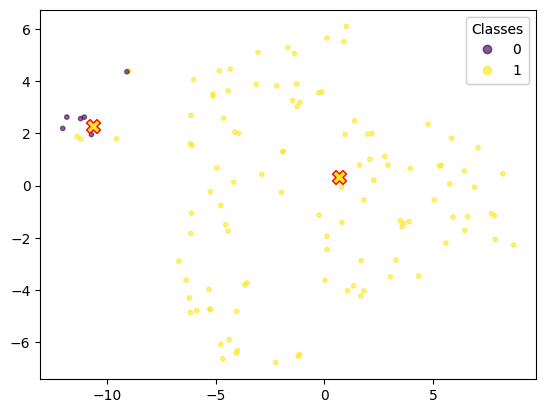

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed, post_train_label, and labelsNums are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Plot the data points
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labelsNums[:len(X_embedded)], s=10, cmap='viridis', alpha=0.6)

# Calculate class representatives
representatives = get_class_rep(post_train_embed, post_train_label)  # Make sure this function returns what you expect

# Get unique labels and their colors from the scatter plot
unique_labels = np.unique(labelsNums[:len(X_embedded)])
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# For each class representative, find the closest point and plot it
for i, rep in enumerate(representatives):
    if rep is not None:
        # Find the closest data point in the original space to this representative
        distances = np.linalg.norm(X_np - rep, axis=1)
        closest_point_index = np.argmin(distances)
        # Use the label of the closest data point to get the correct color
        label_of_closest = labelsNums[closest_point_index]
        color = scatter.cmap(scatter.norm(label_of_closest))
        plt.scatter(X_embedded[closest_point_index, 0], X_embedded[closest_point_index, 1], color=color, edgecolors='red', s=100, marker='X')

# You might want to adjust the legend to make sure it correctly represents your data
# plt.legend()
plt.show()


In [42]:
from sklearn.metrics import f1_score
# Create reverse mapping

count = 0

# Assuming val_dataset is iterable and has 'anchor' and 'label' keys
predicted_labels = []
true_labels = []

for item in val_dataset:
    count += 1
    input_vector = item['anchor']  # Your input vector for prediction
    
    # Get predicted cluster/label
    predicted_label_str = predict(input_vector)
    
    # Ensure predicted_label is in the valid range
    if predicted_label_str in label_to_int:
        predicted_label = label_to_int[predicted_label_str]
        predicted_labels.append(predicted_label)
    else:
        print(f"Warning: Encountered unknown predicted label {predicted_label_str}")
        continue

    # True label
    true_label_int = int(item['label'])  # Assuming 'label' contains the true label as integer
    if true_label_int in int_to_label:
        true_labels.append(true_label_int)
    else:
        print(f"Warning: Encountered unknown true label {true_label_int}")
        continue

    print(count, "Predicted:", predicted_label, "True:", true_label_int)

# Filter out any invalid entries where predicted or true labels are missing
valid_indices = [i for i in range(len(true_labels)) if true_labels[i] in int_to_label and predicted_labels[i] in int_to_label]
filtered_true_labels = [true_labels[i] for i in valid_indices]
filtered_predicted_labels = [predicted_labels[i] for i in valid_indices]

print("Loop completed")

# Calculate F1 Score, ignoring unknown labels
f1 = f1_score(filtered_true_labels, filtered_predicted_labels, average='weighted', zero_division=0)  # Adjust 'average' as necessary
print(f"F1 Score: {f1}")


1 Predicted: 1 True: 1
2 Predicted: 1 True: 1
3 Predicted: 1 True: 1
4 Predicted: 1 True: 1
5 Predicted: 1 True: 1
6 Predicted: 1 True: 1
7 Predicted: 1 True: 1
8 Predicted: 1 True: 1
9 Predicted: 1 True: 1
10 Predicted: 1 True: 1
11 Predicted: 1 True: 1
12 Predicted: 1 True: 1
13 Predicted: 1 True: 1
14 Predicted: 1 True: 1
15 Predicted: 1 True: 1
16 Predicted: 0 True: 1
17 Predicted: 1 True: 1
18 Predicted: 1 True: 1
19 Predicted: 1 True: 1
20 Predicted: 1 True: 1
21 Predicted: 1 True: 1
22 Predicted: 1 True: 1
23 Predicted: 1 True: 1
24 Predicted: 1 True: 1
25 Predicted: 1 True: 1
26 Predicted: 1 True: 1
27 Predicted: 1 True: 1
28 Predicted: 0 True: 1
29 Predicted: 1 True: 0
30 Predicted: 1 True: 1
Loop completed
F1 Score: 0.9157894736842105


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      0.93      0.95        29

    accuracy                           0.90        30
   macro avg       0.48      0.47      0.47        30
weighted avg       0.93      0.90      0.92        30


 - Accuracy :  0.9
 - Precision :  0.93
 - Recall :  0.9
 - F1 score :  0.92
 - MCC :  -0.05
 - AUC :  0.47


Performances by categories



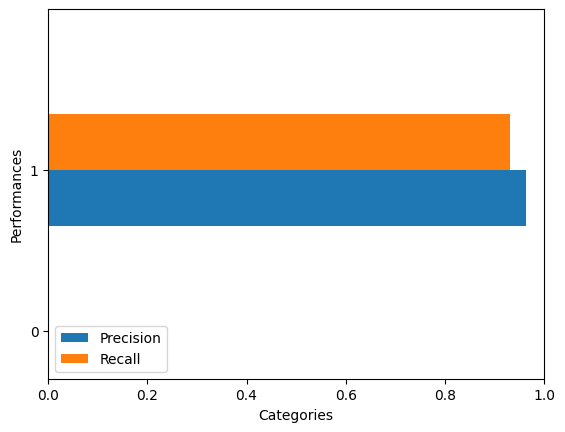



Confusion Matrix 


<AxesSubplot:>

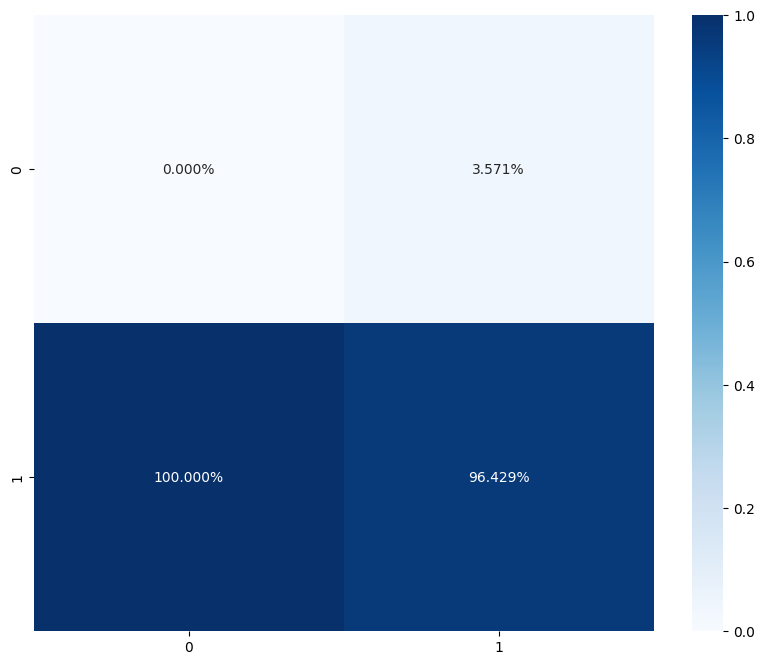

In [43]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

%matplotlib inline
warnings.filterwarnings("ignore")

def multiclass_roc_auc_score(truth, pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

# Assuming predicted_labels and true_labels are already defined
predicted = predicted_labels
labels = true_labels

# Filter out 'unknown' labels
valid_indices = [i for i, label in enumerate(labels) if label != 'unknown']
filtered_labels = [labels[i] for i in valid_indices]
filtered_predicted = [predicted[i] for i in valid_indices]

unique_labels = list(set(filtered_labels))
print(classification_report(filtered_labels, filtered_predicted))

print('\n - Accuracy : ', np.round(metrics.accuracy_score(filtered_labels, filtered_predicted), 2))
print(' - Precision : ', np.round(metrics.precision_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - Recall : ', np.round(metrics.recall_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - F1 score : ', np.round(metrics.f1_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - MCC : ', np.round(metrics.matthews_corrcoef(filtered_labels, filtered_predicted), 2))
print(' - AUC : ', np.round(multiclass_roc_auc_score(filtered_labels, filtered_predicted), 2))

print("\n\nPerformances by categories\n")

ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(filtered_labels, filtered_predicted, labels=unique_labels)[0]
recall = metrics.precision_recall_fscore_support(filtered_labels, filtered_predicted, labels=unique_labels)[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind, yticklabels=np.array(unique_labels), ylim=[2*width - 1, len(ind)])
plt.xlim(0, 1)
ax.legend(loc='lower left')
ax.set_ylabel("Performances")
ax.set_xlabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(filtered_labels, filtered_predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index=[i for i in unique_labels], columns=[i for i in unique_labels])
plt.figure(figsize=(10, 8))
sn.heatmap(df_cm / np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')


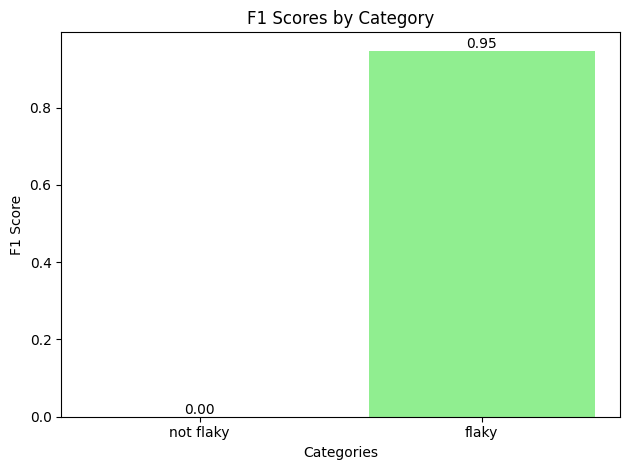

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
shortened_labels = {
    'notFlaky':'not flaky',
    'Flaky': 'flaky'
}
# Assuming you have the predicted and true labels as per your previous code
# predicted_labels and true_labels should be lists of labels
# Filter out invalid labels from both true and predicted labels
valid_indices = [i for i in range(len(true_labels)) if true_labels[i] in int_to_label.keys() and predicted_labels[i] in int_to_label.keys()]
filtered_true_labels = [true_labels[i] for i in valid_indices]
filtered_predicted_labels = [predicted_labels[i] for i in valid_indices]

# Calculate F1 scores for each category
f1_scores = []
categories = list(int_to_label.keys())
for category in categories:
    true_bin = [1 if label == category else 0 for label in filtered_true_labels]
    pred_bin = [1 if label == category else 0 for label in filtered_predicted_labels]
    f1 = f1_score(true_bin, pred_bin, zero_division=0)
    f1_scores.append(f1)

# Define vibrant colors for each category
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']

# Create bar plot with shortened category names and vibrant colors
shortened_categories = [shortened_labels[int_to_label[category]] for category in categories]
fig, ax = plt.subplots()
bars = ax.bar(shortened_categories, f1_scores, color=colors)

# Add F1 scores on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 0),  
                textcoords="offset points", ha='center', va='bottom')

# Customize the plot
ax.set_xlabel('Categories')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Category')

# Display the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
